In [1]:
import itertools
import pathlib
import pyam # version: 1.4.1.dev15+g3563b43

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# these functions can be found in utils.py in this same directory
from utils import (
    make_gap_data,
    make_gap_plot,
)

sns.set_style('whitegrid')

<IPython.core.display.Javascript object>

# Load Data

In [2]:
data_path = pathlib.Path('../data')

In [3]:
paper_data = pd.concat([
    pd.read_csv(data_path / 'gidden_et_al_2022_ar6_reanalysis_data.csv'),
    pd.read_csv(data_path / 'additional_analysis_data.csv'),
])
df = pyam.IamDataFrame(paper_data)
df.load_meta(data_path / 'gidden_et_al_2022_ar6_reanalysis_meta.csv')

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading meta indicators


In [4]:
categories_to_temp = {'C1': '1.5C', 'C3': '2C'}
df.meta['Temperature'] = df.meta['Category'].replace(categories_to_temp)

In [5]:
kyoto_gases_variable = 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases'

# Figure 2A

In [6]:
variables = [
    kyoto_gases_variable,
]
quantiles = (0.1, 0.25, 0.5, 0.75, 0.9)
year_start, year_end = 2010, 2100

data = pyam.concat([
    (
        df
        .filter(region='World', variable=variable, year=range(year_start, year_end + 1))
        .filter(Category=category)
        .convert_unit('Mt CO2-equiv/yr', to='Gt CO2-equiv/yr', factor=1e-3)
        .quantiles(quantiles)
        .rename(model={'unweighted': temp})
    ) for (category, temp), variable in itertools.product(categories_to_temp.items(), variables)
])

for variable in variables:
    data.append(
        df
        .filter(region='World', variable=variable, year=range(year_start, year_end + 1))
        .filter(Policy_category_name='P1b: Current policies')
        .convert_unit('Mt CO2-equiv/yr', to='Gt CO2-equiv/yr', factor=1e-3)
        .quantiles(quantiles)
        .rename(model={'unweighted': 'Current Policies'}),
        inplace=True
    )

In [7]:
targets = pd.DataFrame([
    ('Current Policies (den Elzen 2022, adj.)', 56.826, 52.592, 59.552, 'dimgrey', 0),
    ('Conditional NDCs (den Elzen 2022, adj.)', 50.700, 48.542, 52.202, 'plum', -0.35),
    ('Unconditional NDCs (den Elzen 2022, adj.)', 52.284, 50.059, 54.136, 'thistle', 0.35),
], columns=['label', 'med', 'min', 'max', 'color', 'jitter'])

target_2015_value = 51.181
this_study_2015_value = (
    data
    .filter(variable=kyoto_gases_variable, year=2015, scenario='quantile_0.5')
    .timeseries()
    .mean()
    .iloc[0]
)
target_offset = target_2015_value - this_study_2015_value
target_2015_value, this_study_2015_value, target_offset

(51.181, 50.87593403429545, 0.30506596570455)

In [8]:
color_map = {
    'Current Policies': '#' + 'a' * 6,
    '2C': [1.        , 0.85098039, 0.18431373, 1.        ],
    '1.5C': [0.55294118, 0.62745098, 0.79607843, 1.        ], 
}
rc = pyam.run_control()
#rc.store['color']['model'] = {}
rc.update({'color': {'model': color_map}})

C:\Users\gidden\Miniconda3\envs\pyam\lib\site-packages\numpy\lib\arraysetops.py:590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar1 = np.asarray(ar1).ravel()
C:\Users\gidden\Miniconda3\envs\pyam\lib\site-packages\numpy\lib\arraysetops.py:590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar1 = np.asarray(ar1).ravel()


(0.0, 70.0)

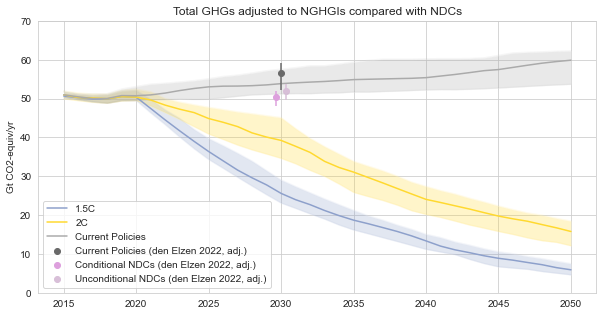

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
(
    data
    .filter(variable=kyoto_gases_variable, year=range(2015, 2051))
    .filter(scenario=['*0.25*', '*0.75*'])
    .plot
    .line(color='model', fill_between=True, ax=ax, alpha=0.1)
)
(
    data
    .filter(variable=kyoto_gases_variable, year=range(2015, 2051))
    .filter(scenario='quantile_0.5')
    .plot
    .line(color='model', ax=ax, cmap='Set2')
)
for i, row in targets.iterrows():
    ax.scatter(2030 + row['jitter'], row['med'] - target_offset, label=row['label'], c=row['color'])
    ax.errorbar(2030 + row['jitter'], row['med'] - target_offset, 
                yerr=np.array([[row['med'] - row['min'], row['max'] - row['med']],]).reshape(2, 1), 
                color=row['color'])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[6:], labels[6:])
ax.set_title('Total GHGs adjusted to NGHGIs compared with NDCs')
ax.set_xlabel('')
ax.set_ylim(0, 70)

## Gap quantification

In [10]:
med_target = targets.set_index('label')['med'] - target_offset
med_target

label
Current Policies (den Elzen 2022, adj.)      56.520934
Conditional NDCs (den Elzen 2022, adj.)      50.394934
Unconditional NDCs (den Elzen 2022, adj.)    51.978934
Name: med, dtype: float64

In [11]:
pathways = (
    data
    .filter(variable=kyoto_gases_variable, year=2030, scenario=['*0.5*'])
    .timeseries()
    [2030]
    .unstack('model')
    .reset_index(drop=True)
)
pathways

model,1.5C,2C,Current Policies
0,25.603657,39.248447,53.865406


In [12]:
gap = pd.DataFrame({c: med_target - float(pathways[c]) for c in pathways})
gap

,1.5C,2C,Current Policies
label,,,
"Current Policies (den Elzen 2022, adj.)",30.917277,17.272487,2.655528
"Conditional NDCs (den Elzen 2022, adj.)",24.791277,11.146487,-3.470472
"Unconditional NDCs (den Elzen 2022, adj.)",26.375277,12.730487,-1.886472


In [13]:
(12.7 - 10.8) / 10.8 # 2C

0.1759259259259258

In [14]:
(25.4 - 27.6) / 27.6

-0.07971014492753634

# Figure 2B

In [15]:
# change in emissions in negative, gap is positive
adj = -1 * make_gap_data(df, 'Change in AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases from 2020', categories_to_temp)
orig = -1 * make_gap_data(df, 'Change in AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only from 2020', categories_to_temp)

Text(0.5, 1.0, 'Change in 2030 regional emission reductions between \npathways with and without the NGHGI correction')

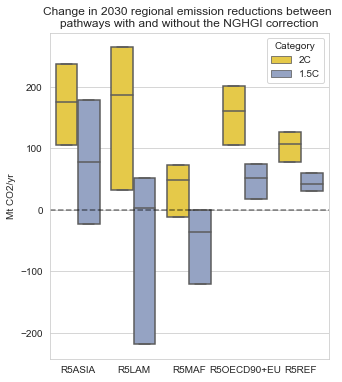

In [16]:
fig, ax = plt.subplots(figsize=(5, 6))

make_gap_plot(adj-orig, drop={'region': 'World'}, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Mt CO2/yr')
ax.set_title(
    'Change in 2030 regional emission reductions between \n'
    'pathways with and without the NGHGI correction'
)

Text(0.5, 1.0, 'Change in 2030 regional emission reductions between \npathways with and without the NGHGI correction')

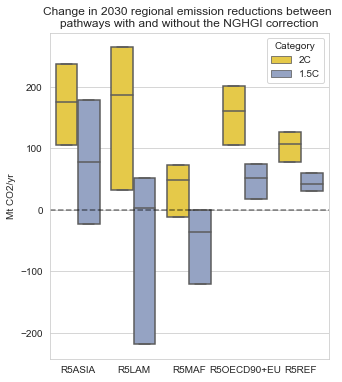

In [17]:
fig, ax = plt.subplots(figsize=(5, 6))

make_gap_plot(adj-orig, drop={'region': 'World'}, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Mt CO2/yr')



ax.set_title(
    'Change in 2030 regional emission reductions between \n'
    'pathways with and without the NGHGI correction'
)

## Figure for SI

Text(0.5, 1.0, 'Change in 2030 regional emission reductions required \nto limit warming relative to the reductions not aligned to NGHGIs')

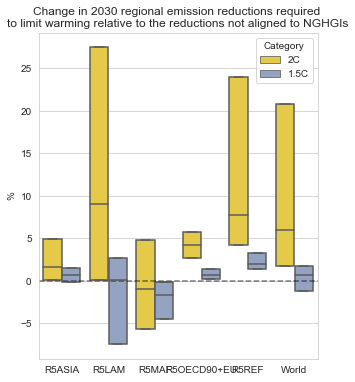

In [18]:
fig, ax = plt.subplots(figsize=(5, 6))

make_gap_plot(100 * ((adj / orig) - 1), ax=ax)
ax.set_xlabel('')
ax.set_ylabel('%')

ax.set_title(
    'Change in 2030 regional emission reductions required \n'
    'to limit warming relative to the reductions not aligned to NGHGIs'
)